# A Practical Guide to Object Detection using the Popular YOLO Framework

## Link: [YOLO Tutorial](https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/)

### Mounting Drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Uploading and Extracting the weights

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/Dataset and libraries.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## 1 - Importing Libraries

In [0]:
import sys
sys.path.append('/tmp/week3')

import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

### Creating function to draw_boxes

In [0]:
from PIL import Image, ImageDraw, ImageFont

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font="/tmp/week3/font/arial.ttf",size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

## 2 - Creating function to filter boxes based on probabilities and threshold

In [0]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores,-1)
    box_class_scores = K.max(box_scores,-1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
 
    return scores, boxes, classes

## 3 - Defining function to calculate the IOU between two boxes

In [0]:
def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
 
    return iou

## 4 - Defining a function to Non-Max Suppression

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

## 5 - Creating a random volume and then predicting the bounding boxes

In [0]:
yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))

## 6 - Creating function that takes the output of the CNN and return the suppressed boxes

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

### Testing

In [0]:
scores, boxes, classes = yolo_eval(yolo_outputs)

In [0]:
with tf.Session() as test_b:
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


## 7 - Using a pretrained YOLO on new images

In [0]:
# Loading model

sess = K.get_session()
class_names = read_classes("/tmp/week3/model_data/coco_classes.txt")
anchors = read_anchors("/tmp/week3/model_data/yolo_anchors.txt")

yolo_model = load_model("/tmp/week3/model_data/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# Getting the yolo outputs
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

### Defining function to predict the bounding boxes and save the images with the boxes

In [0]:
def predict(sess, image_file):
    image, image_data = preprocess_image("/tmp/week3/images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)

    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    # Save the predicted bounding box on the image
    image.save(os.path.join("/tmp/week3/out/", image_file), quality=90)

    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("/tmp/week3/out/", image_file))

    plt.figure(figsize=(12,12))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

### Read image and make predictions

In [0]:
# Modifying line 52 yolo_utils -> Removing font
import shutil

shutil.move("/yolo_utils.py", "/tmp/week3")

'/tmp/week3/yolo_utils.py'

In [0]:
# Uploading and moving image
import shutil

shutil.move("/img.jpg", "/tmp/week3/images")

Error: ignored

In [0]:
# Uploading and moving font
import shutil

shutil.move("/arial.ttf", "/tmp/week3/font")

'/tmp/week3/font/arial.ttf'

In [0]:
img = plt.imread('/tmp/week3/images/img.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 4 boxes for img.jpg
traffic light 0.62 (381, 93) (407, 146)
car 0.66 (246, 298) (336, 366)
car 0.70 (369, 292) (451, 357)
car 0.75 (150, 313) (245, 375)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


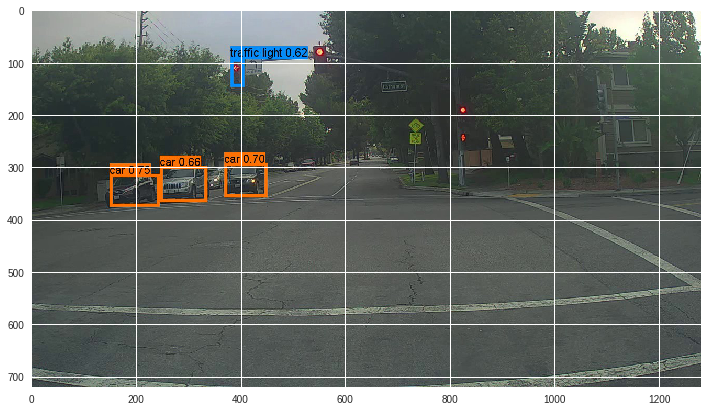

In [0]:
# Plotting predictions
out_scores, out_boxes, out_classes = predict(sess, "img.jpg")